# 1. Objectives

1. Predict Seeding based on Season Statistics. Analyze leading predictors of seeding outcome.
2. Predict Tournament Results Based on Seeding and Season Statistics. Do not worry about matchups.
3. Test Models on 2021 data.

# 2. Importing and Cleaning the Data

For my project, I want to predict college basketball tournament seeding and national champions based on the season's stastics. From kaggle.com, there are available data sets from the 2013-2021 basketball seasons (excluding 2020 due to cancelled tournament). The columns of the data set with associated descriptions are as follows:
- TEAM: name of team being analyzed
- CONF: name of conference the team plays for
- G: Games played
- W: Games won
- ADJOE: Adjusted Offensive Efficiency (Estimate of Average Points Scored per 100 Posessions)
- ADJDE: Adjusted Defensive Efficiency (Estimate of Average Points Allowed per 100 Posessions)
- BARTHAG: Power Rating (Chance of Beating an average D1 team)
- EFG_O: Field Goal Percentage
- EFG_D: Field Goal Percentage Allowed
- TOR: Turnover Percentage
- TORD: Steal Rate
- ORB: Offensive Rebound Rate
- DRB: Defensive Rebound Rate
- FTR: Free Throw Rate
- FTRD: Free Throw Rate Allowed
- 2P_O: Two-Point Shooting Percentage
- 2P_D: Two-Point Shooting Percentage Allowed
- 3P_O: Three-Point Shooting Percentage
- 3P_D: Three-Point Shooting Percentage Allowed
- ADJ_T: Adjusted Tempo (Posessions per 40 minutes)
- WAB: Wins Above Bubble (Wins against top teams)
- POSTSEASON: Result of Tournament
- SEED: Seed in the NCAA March Madness Tournament
- YEAR: Which year the data was drawn from

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#data set from https://www.kaggle.com/andrewsundberg/college-basketball-dataset?select=cbb.csv
rawdata = pd.read_csv("C:/Users/kharm/OneDrive/Documents/JobDocuments/Summer2022/Hawks/Mini-Project1/cbb.csv") #2013-2019 seasons
rawdata.head(10)

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017
5,Kentucky,SEC,40,29,117.2,96.2,0.9062,49.9,46.0,18.1,...,36.8,50.0,44.9,33.2,32.2,65.9,3.9,2ND,8.0,2014
6,Michigan,B10,38,30,121.5,93.7,0.9522,54.6,48.0,14.6,...,22.7,53.4,47.6,37.9,32.6,64.8,6.2,2ND,4.0,2013
7,Duke,ACC,39,35,125.2,90.6,0.9764,56.6,46.5,16.3,...,23.9,55.9,46.3,38.7,31.4,66.4,10.7,Champions,1.0,2015
8,Virginia,ACC,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,...,26.3,52.5,45.7,39.5,28.9,60.7,11.1,Champions,1.0,2019
9,North Carolina,ACC,39,33,121.0,91.5,0.9615,51.7,48.1,16.2,...,31.6,51.0,46.3,35.5,33.9,72.8,8.4,Champions,1.0,2017


In [3]:
for col in rawdata.columns: #cycles through columns
    if sum(rawdata[col].isna()) != 0: #detecting any NAs
        print(col) #printing any column with an NA
    elif sum(rawdata[col].isnull()) != 0: #detecting and NULL
        print(col) #printing any column with a NULL (that did not already register with NA)
        
for i in range(len(rawdata.duplicated())):
    if rawdata.duplicated()[i] == True:
        print("Entry " + str(i) + " is duplicated.")

POSTSEASON
SEED


It is okay that SEED and POSTSEASON have some empty columns; not all teams can make the tournament or get to the Elite 8. There are no visible duplications. Now, let's check that the data set is complete.

In [4]:
# We have 68 teams that make the tournament every year and 7 years to consider. So we should have 476 teams that receive seeds.
if (rawdata.shape[0] - sum(rawdata["SEED"].isna())) == 476:
    print("All seeds are recorded.")
    
# Additionally, we should see 476 tournament results
if (rawdata.shape[0] - sum(rawdata["POSTSEASON"].isna())) == 476:
    print("All Postseasons are recorded.")

All seeds are recorded.
All Postseasons are recorded.


The data set appears to be complete. If it was not, NA's would be interpolated based on their team average (conference if team was unavailable). If the results showed any extreme discrepencies based on that filtering, the points (school) would be removed all together. Duplicated occurances would also be removed.

In [5]:
data = rawdata

In [6]:
SEEDSCORE = rawdata["SEED"]
SEEDSCORE[rawdata["SEED"].isna()] = 17
SEEDSCORE = SEEDSCORE.to_numpy().astype(float)
data["SEEDSCORE"] = 17 - SEEDSCORE

data["SEED"][rawdata["SEED"].isna()] = "NTA"

'''
TGBL = rawdata["POSTSEASON"]
for a in range(len(data["POSTSEASON"])):
    if data["POSTSEASON"][a] == "Champions":
        TGBL[a] = 7.0
    elif data["POSTSEASON"][a] == "R68":
        TGBL[a] = 0.0
    elif data["POSTSEASON"][a] == "R64":
        TGBL[a] = 1.0
    elif data["POSTSEASON"][a] == "R32":
        TGBL[a] = 2.0
    elif data["POSTSEASON"][a] == "S16":
        TGBL[a] = 3.0
    elif data["POSTSEASON"][a] == "E8":
        TGBL[a] = 4.0
    elif data["POSTSEASON"][a] == "F4":
        TGBL[a] = 5.0
    elif data["POSTSEASON"][a] == "2ND":
        TGBL[a] = 6.0
    else:
        TGBL[a] = 0.0
data["TGBL"] = TGBL.to_numpy().astype(float)
'''

data["POSTSEASON"][rawdata["POSTSEASON"].isna()] = "NTA"
data["POSTSEASON"] = data["POSTSEASON"].astype(object)

data["TEAM"] = data["TEAM"].astype(object)
data["CONF"] = data["CONF"].astype(object)

C:\Users\kharm\AppData\Local\Temp/ipykernel_23352/2430287804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SEEDSCORE[rawdata["SEED"].isna()] = 17
C:\Users\kharm\AppData\Local\Temp/ipykernel_23352/2430287804.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["SEED"][rawdata["SEED"].isna()] = "NTA"
C:\Users\kharm\AppData\Local\Temp/ipykernel_23352/2430287804.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["POSTSEASO

# 3. Data Manipulation

### 3a. Adjusting Data for Seeding Analysis

In [7]:
seeddata = data.drop(columns = ["POSTSEASON"])
YEARTEAM = []
for a in range(len(rawdata)):
    YEARTEAM.append(str(seeddata["YEAR"][a])+ " " + str(seeddata["TEAM"][a]))
seeddata["YEARTEAM"] = YEARTEAM
#seeddata = seeddata.drop(columns = ["YEAR","TEAM"])
seeddata = seeddata.set_index("YEARTEAM")
seeddata.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR,SEEDSCORE
YEARTEAM,,,,,,,,,,,,,,,,,,,,,
2016 North Carolina,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1.0,2016,16.0
2015 Wisconsin,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1.0,2015,16.0
2018 Michigan,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,3.0,2018,14.0
2019 Texas Tech,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,3.0,2019,14.0
2017 Gonzaga,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,1.0,2017,16.0


Now to adjust data based on statistical findings:

In [8]:
from sklearn.model_selection import train_test_split

seedX = seeddata.drop(columns = ["YEAR","EFG_D","TORD","DRB","FTRD","2P_O","2P_D","3P_O","3P_D","ADJ_T","SEED","SEEDSCORE"])
seedy = seeddata["SEEDSCORE"]

sXtrain, sXtest, sytrain, sytest = train_test_split(seedX, seedy, test_size=0.25, random_state = 1)

### 3b. Adjusting Data for the Postseason Analysis

In [9]:
resultdata = data
YEARTEAM = []
for a in range(len(rawdata)):
    YEARTEAM.append(str(resultdata["YEAR"][a])+ " " + str(resultdata["TEAM"][a]))
resultdata["YEARTEAM"] = YEARTEAM
for a in range(resultdata.shape[0]):
    if resultdata["POSTSEASON"][a] == "NTA":
        resultdata = resultdata.drop(a, axis = 0)
resultdata = resultdata.set_index("YEARTEAM")
resultdata.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,SEEDSCORE
YEARTEAM,,,,,,,,,,,,,,,,,,,,,
2016 North Carolina,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016,16.0
2015 Wisconsin,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015,16.0
2018 Michigan,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018,14.0
2019 Texas Tech,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019,14.0
2017 Gonzaga,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017,16.0


In [10]:
#will include seeding initially even with colinearity
resultX = resultdata.drop(columns = ["YEAR","EFG_O","EFG_D","TOR","TORD","ORB","FTR","FTRD","2P_O","2P_D","3P_O","3P_D","ADJ_T","POSTSEASON","SEED"])
resulty = resultdata["POSTSEASON"]

rXtrain, rXtest, rytrain, rytest = train_test_split(resultX, resulty, test_size=0.25, random_state = 1)

# 4. Support Vector Machines

In [11]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

### 4a. Seeding Predictions

In [12]:
sScale = StandardScaler()
sScale.fit(sXtrain.drop(columns = ["TEAM","CONF"]))
sXtrain_scale = sScale.transform(sXtrain.drop(columns = ["TEAM", "CONF"]))
sXtest_scale = sScale.transform(sXtest.drop(columns = ["TEAM", "CONF"]))

In [13]:
svm_param = {'C': [0.01, 0.05, 0.1, 0.2], #regularization parameter
              'degree': [1, 2, 3], #possible degrees of polynomial if "poly" kernel is used
              'gamma': [1, 3, 5], #kernel coefficient
              'kernel': ["linear","poly","rbf"], #kernel for algorithm
              'probability': [True]} #parameters to test for svm

grid_search1 = GridSearchCV(SVC(), svm_param, cv=3, n_jobs=10,
                          return_train_score=True, scoring='accuracy', verbose=2) #running through parameters for svm

grid_search1.fit(sXtrain_scale, sytrain) #using data to find best fit

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=10,
             param_grid={'C': [0.01, 0.05, 0.1, 0.2], 'degree': [1, 2, 3],
                         'gamma': [1, 3, 5],
                         'kernel': ['linear', 'poly', 'rbf'],
                         'probability': [True]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [14]:
print("Best parameters: " + str(grid_search1.best_params_)) #best parameters
print("Best cross-validation score: " + str(grid_search1.best_score_)) #with best accuracy

Best parameters: {'C': 0.2, 'degree': 1, 'gamma': 5, 'kernel': 'poly', 'probability': True}
Best cross-validation score: 0.8256372515157473


In [15]:
svmseed = SVC(**grid_search1.best_params_) #new model with parameters

svmseed.fit(sXtrain_scale,sytrain) #fitting training data
seedpred = svmseed.predict(sXtest_scale) #prediction test set

In [16]:
print("accuracy:", accuracy_score(sytest,seedpred)) #accuracy

accuracy: 0.8501628664495114


### 4b. Result Predictions

In [17]:
rScale = StandardScaler()
rScale.fit(rXtrain.drop(columns=["TEAM","CONF"]))
rXtrain_scale = rScale.transform(rXtrain.drop(columns=["TEAM","CONF"]))
rXtest_scale = rScale.transform(rXtest.drop(columns = ["TEAM","CONF"]))

In [18]:
grid_search2 = GridSearchCV(SVC(), svm_param, cv=3, n_jobs=10,
                          return_train_score=True, scoring='accuracy', verbose=2)

grid_search2.fit(rXtrain_scale,rytrain)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=10,
             param_grid={'C': [0.01, 0.05, 0.1, 0.2], 'degree': [1, 2, 3],
                         'gamma': [1, 3, 5],
                         'kernel': ['linear', 'poly', 'rbf'],
                         'probability': [True]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [19]:
print("Best parameters: " + str(grid_search2.best_params_)) #best parameters
print("Best cross-validation score: " + str(grid_search2.best_score_)) #with best accuracy

Best parameters: {'C': 0.2, 'degree': 1, 'gamma': 1, 'kernel': 'linear', 'probability': True}
Best cross-validation score: 0.5742296918767508


In [20]:
svmresult = SVC(**grid_search2.best_params_)

svmresult.fit(rXtrain_scale,rytrain)
resultpred = svmresult.predict(rXtest_scale)

In [21]:
print("SVM Accuracy:", accuracy_score(rytest,resultpred)) #accuracy

SVM Accuracy: 0.6386554621848739


# 5. Decision Tree Classifiers

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

### 5a. Seeding Predictions

In [23]:
seed_tree = DecisionTreeClassifier(max_depth = 16,min_samples_leaf=20,random_state=1)
seed_tree.fit(sXtrain.drop(columns = ["TEAM","CONF"]),sytrain)

DecisionTreeClassifier(max_depth=16, min_samples_leaf=20, random_state=1)

In [24]:
seed_tree_pred = seed_tree.predict(sXtest.drop(columns = ["TEAM","CONF"]))

print("Decision Tree Accuracy of Testing Set: " + str(accuracy_score(sytest,seed_tree_pred))) #test accuracy

Decision Tree Accuracy of Testing Set: 0.8452768729641694


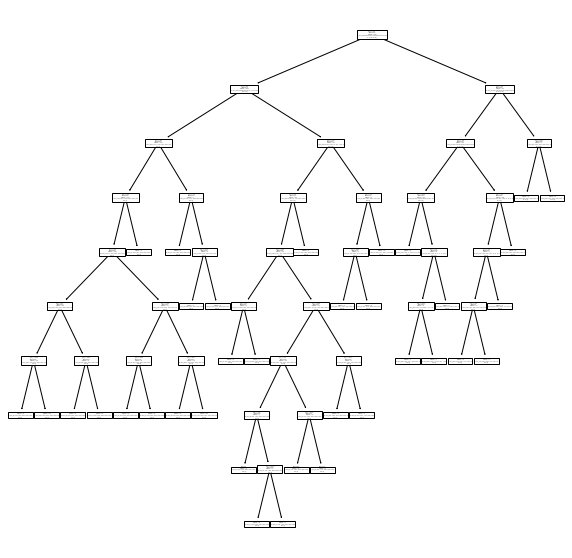

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10,10])
seedplot = tree.plot_tree(seed_tree)

### 5b. Results Predictions

In [26]:
result_tree = DecisionTreeClassifier(max_depth = 7,random_state=1)
result_tree.fit(rXtrain.drop(columns = ["TEAM","CONF"]),rytrain)

DecisionTreeClassifier(max_depth=7, random_state=1)

In [27]:
result_tree_pred = result_tree.predict(rXtest.drop(columns = ["TEAM","CONF"]))

print("Decision Tree Accuracy of Testing Set: " + str(accuracy_score(rytest,result_tree_pred))) #test accuracy

Decision Tree Accuracy of Testing Set: 0.4957983193277311


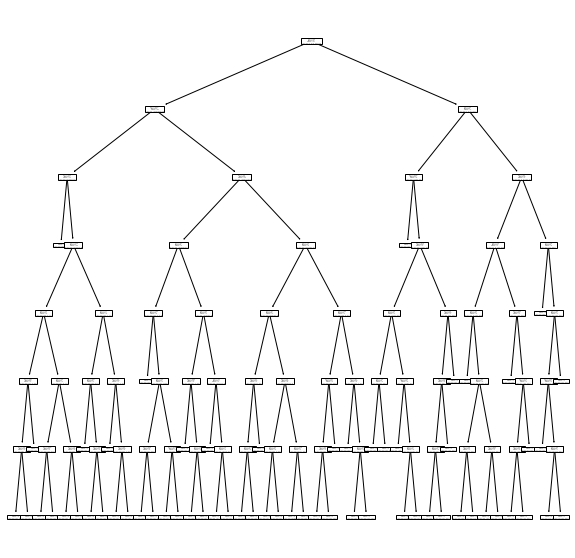

In [28]:
plt.figure(figsize=[10,10])
resultplot = tree.plot_tree(result_tree)

# 6. K-Nearest Neightbor

In [29]:
from sklearn.neighbors import KNeighborsClassifier

### 6a. Seed Projections

In [30]:
knn_param = {'n_neighbors': [2, 3, 4, 5],
              'metric': ["euclidean", "manhattan", "minkowski"]}

grid_search3 = GridSearchCV(KNeighborsClassifier(n_jobs=17), knn_param, cv=3,
                          return_train_score=True, scoring='accuracy')

grid_search3.fit(sXtrain.drop(columns=["TEAM","CONF"]), sytrain) #fitting training data to find parameters

GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=17),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [2, 3, 4, 5]},
             return_train_score=True, scoring='accuracy')

In [31]:
print("Best parameters: " + str(grid_search3.best_params_)) #best parameters
print("Best cross-validation score: " + str(grid_search3.best_score_)) #with best accuracy

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best cross-validation score: 0.8120623905146013


In [32]:
seedknn = KNeighborsClassifier(**grid_search3.best_params_) #new model with parameters

seedknn.fit(sXtrain.drop(columns = ["TEAM","CONF"]), sytrain)
seed_knn_pred = seedknn.predict(sXtest.drop(columns = ["TEAM","CONF"]))
print("K - Nearest Neighbors Accuracy:", accuracy_score(sytest,seed_knn_pred)) #accuracy

K - Nearest Neighbors Accuracy: 0.8338762214983714


### 6b. Result Projections

In [33]:
grid_search4 = GridSearchCV(KNeighborsClassifier(n_jobs=8), knn_param, cv=3,
                          return_train_score=True, scoring='accuracy')

grid_search4.fit(rXtrain.drop(columns=["TEAM","CONF"]), rytrain) #fitting training data to find parameters

GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=8),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [2, 3, 4, 5]},
             return_train_score=True, scoring='accuracy')

In [34]:
print("Best parameters: " + str(grid_search4.best_params_)) #best parameters
print("Best cross-validation score: " + str(grid_search4.best_score_)) #with best accuracy

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best cross-validation score: 0.5042016806722689


In [35]:
resultknn = KNeighborsClassifier(**grid_search4.best_params_) #new model with parameters

resultknn.fit(rXtrain.drop(columns = ["TEAM","CONF"]), rytrain)
result_knn_pred = resultknn.predict(rXtest.drop(columns = ["TEAM","CONF"]))
print("K - Nearest Neighbors Accuracy:", accuracy_score(rytest,result_knn_pred)) #accuracy

K - Nearest Neighbors Accuracy: 0.5294117647058824


# 7. Testing with 2021


In [36]:
lydata = pd.read_csv("C:/Users/kharm/OneDrive/Documents/JobDocuments/Summer2022/Hawks/Mini-Project1/cbbdata.csv")
lydata.head() #Last Year's Data

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
0,Michigan,B10,24,20,118.1,91.1,0.9521,54.9,44.9,16.3,...,24.8,28.9,24.5,53.3,42.3,38.7,33.5,66.9,7.2,1.0
1,Baylor,B12,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,...,30.9,27.0,31.7,54.1,48.1,41.8,34.0,68.8,6.6,1.0
2,Illinois,B10,29,23,117.7,90.4,0.9539,55.6,46.6,18.2,...,22.2,39.2,30.5,55.3,45.4,37.6,32.7,70.7,8.9,1.0
3,Gonzaga,WCC,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,...,23.4,36.7,25.9,64.0,46.8,36.5,32.5,74.6,8.5,1.0
4,Iowa,B10,29,21,123.5,95.7,0.9491,54.6,48.3,13.3,...,28.6,32.0,22.6,52.4,45.8,38.6,34.8,70.0,5.6,2.0


In [37]:
newdata = lydata

SEEDSCORE2 = lydata["SEED"]
SEEDSCORE2[lydata["SEED"].isna()] = 17
SEEDSCORE2 = SEEDSCORE2.to_numpy().astype(float)
newdata["SEEDSCORE"] = 17 - SEEDSCORE2

newdata["SEED"][lydata["SEED"].isna()] = "NTA"

C:\Users\kharm\AppData\Local\Temp/ipykernel_23352/1353607762.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SEEDSCORE2[lydata["SEED"].isna()] = 17
C:\Users\kharm\AppData\Local\Temp/ipykernel_23352/1353607762.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata["SEED"][lydata["SEED"].isna()] = "NTA"


In [38]:
newseedX = newdata.drop(columns = ["TEAM","CONF","EFG_D","TORD","DRB","FTRD","2P_O","2P_D","3P_O","3P_D","ADJ_T","SEED","SEEDSCORE"])
newresultX = newdata.drop(columns = ["TEAM","CONF","EFG_O","EFG_D","TOR","TORD","ORB","FTR","FTRD","2P_O","2P_D","3P_O","3P_D","ADJ_T","SEED"])
for a in range(newdata.shape[0]):
    if newresultX["SEEDSCORE"][a] == 0:
        newresultX = newresultX.drop(a)


In [39]:
#svm
newseedX_scale = sScale.transform(newseedX)
new_seed_svm_pred = svmseed.predict(newseedX_scale)
print("SVM Accuracy for Seeding:", accuracy_score(newdata["SEEDSCORE"],new_seed_svm_pred))

newresultX_scale = rScale.transform(newresultX)
new_result_svm_pred = svmresult.predict(newresultX_scale) #no accuracy because tournament results are not imported

SVM Accuracy for Seeding: 0.8097982708933718


In [40]:
#Decision Tree Classifier
new_seed_tree_pred = seed_tree.predict(newseedX)
print("Decision Tree Accuracy of Testing Set: " + str(accuracy_score(newdata["SEEDSCORE"],new_seed_tree_pred))) #test accuracy

new_result_tree_pred = result_tree.predict(newresultX)

Decision Tree Accuracy of Testing Set: 0.829971181556196


In [41]:
#K-Nearest Neighbors
new_seed_knn_pred = seedknn.predict(newseedX)
print("K - Nearest Neighbors Accuracy:", accuracy_score(newdata["SEEDSCORE"],new_seed_knn_pred)) #accuracy

new_result_knn_pred = resultknn.predict(newresultX)

K - Nearest Neighbors Accuracy: 0.8069164265129684


To put into perspective, take the final four teams from 2021: Baylor (1), Gonzaga (3), UCLA (43), and Houston (6). Look at their results:

In [42]:
newdata.iloc[[1,3,6,43]]

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,SEEDSCORE
1,Baylor,B12,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,...,27.0,31.7,54.1,48.1,41.8,34.0,68.8,6.6,1.0,16.0
3,Gonzaga,WCC,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,...,36.7,25.9,64.0,46.8,36.5,32.5,74.6,8.5,1.0,16.0
6,Houston,Amer,26,24,120.6,90.9,0.9626,51.3,42.9,16.3,...,30.7,42.4,49.9,43.0,35.5,28.5,65.0,4.0,2.0,15.0
43,UCLA,P12,26,17,112.3,97.5,0.8350,52.0,50.7,16.6,...,32.6,28.0,50.6,49.4,36.7,35.1,64.7,1.0,11.0,6.0


In [43]:
print("Baylor's Stats")
print("SVM Projected Seed: " + str(17-new_seed_svm_pred[1]))
print("Decision Tree Projected Seed: " + str(17-new_seed_tree_pred[1]))
print("K - Nearest Neighbnor Projected Seed: " + str(17-new_seed_tree_pred[1]))
print("SVM Projected Result: " + str(new_result_svm_pred[1]))
print("Decision Tree Projected Result: " + str(new_result_tree_pred[1]))
print("K - Nearest Neighbnor Projected Result: " + str(new_result_tree_pred[1]))

Baylor's Stats
SVM Projected Seed: 2.0
Decision Tree Projected Seed: 1.0
K - Nearest Neighbnor Projected Seed: 1.0
SVM Projected Result: R64
Decision Tree Projected Result: R32
K - Nearest Neighbnor Projected Result: R32


In [44]:
print("Gonzaga's Stats")
print("SVM Projected Seed: " + str(17-new_seed_svm_pred[3]))
print("Decision Tree Projected Seed: " + str(17-new_seed_tree_pred[3]))
print("K - Nearest Neighbnor Projected Seed: " + str(17-new_seed_tree_pred[3]))
print("SVM Projected Result: " + str(new_result_svm_pred[3]))
print("Decision Tree Projected Result: " + str(new_result_tree_pred[3]))
print("K - Nearest Neighbnor Projected Result: " + str(new_result_tree_pred[3]))

Gonzaga's Stats
SVM Projected Seed: 3.0
Decision Tree Projected Seed: 1.0
K - Nearest Neighbnor Projected Seed: 1.0
SVM Projected Result: R64
Decision Tree Projected Result: R64
K - Nearest Neighbnor Projected Result: R64


In [45]:
print("Houston's Stats")
print("SVM Projected Seed: " + str(17-new_seed_svm_pred[6]))
print("Decision Tree Projected Seed: " + str(17-new_seed_tree_pred[6]))
print("K - Nearest Neighbnor Projected Seed: " + str(17-new_seed_tree_pred[6]))
print("SVM Projected Result: " + str(new_result_svm_pred[6]))
print("Decision Tree Projected Result: " + str(new_result_tree_pred[6]))
print("K - Nearest Neighbnor Projected Result: " + str(new_result_tree_pred[6]))

Houston's Stats
SVM Projected Seed: 5.0
Decision Tree Projected Seed: 5.0
K - Nearest Neighbnor Projected Seed: 5.0
SVM Projected Result: R64
Decision Tree Projected Result: R64
K - Nearest Neighbnor Projected Result: R64


In [46]:
print("UCLA's Stats")
print("SVM Projected Seed: " + str(17-new_seed_svm_pred[43]))
print("Decision Tree Projected Seed: " + str(17-new_seed_tree_pred[43]))
print("K - Nearest Neighbnor Projected Seed: " + str(17-new_seed_tree_pred[43]))
print("SVM Projected Result: " + str(new_result_svm_pred[43]))
print("Decision Tree Projected Result: " + str(new_result_tree_pred[43]))
print("K - Nearest Neighbnor Projected Result: " + str(new_result_tree_pred[43]))

UCLA's Stats
SVM Projected Seed: 10.0
Decision Tree Projected Seed: 10.0
K - Nearest Neighbnor Projected Seed: 10.0
SVM Projected Result: R64
Decision Tree Projected Result: R68
K - Nearest Neighbnor Projected Result: R68
